In [1]:
from pyinstrument import Profiler

# Import the dependencies
import sys
import pandas as pd
import numpy as np
import time
import numba
from numba.typed import List
#import yappi

from sklearn.datasets import make_classification
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score

from matplotlib import pyplot as plt

## Create a test dataset

In [2]:
# ## Create a test dataset
X, y = make_classification(n_samples=100, n_features=30, n_informative=5, n_redundant=10, n_repeated=15, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=42) 

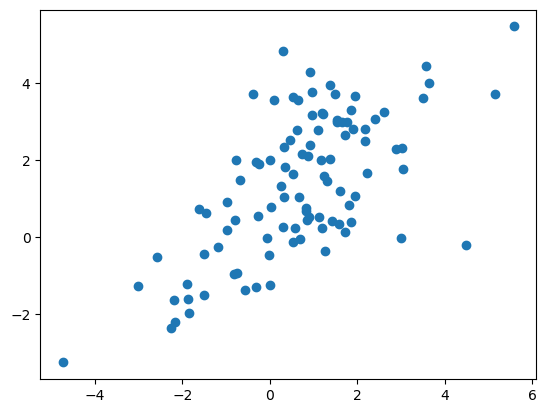

In [3]:
plt.scatter(X[:,0], X[:,1])
plt.show()

In [4]:
test_df = pd.DataFrame(X)
test_df = test_df.add_prefix('feature_')
test_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29
0,0.106783,3.559621,3.200886,-1.466500,1.984403,3.559621,3.200886,2.164707,3.200886,-1.076375,...,-0.673452,3.200886,-1.466500,-0.673452,-1.448977,3.200886,-1.219085,-1.219085,3.559621,2.394649
1,-4.735288,-3.270145,0.498771,5.037043,0.709254,-3.270145,0.498771,1.509421,0.498771,-3.303723,...,0.211675,0.498771,5.037043,0.211675,0.034071,0.498771,0.561535,0.561535,-3.270145,3.113407
2,-2.191540,-1.632500,-0.396140,2.584943,0.010798,-1.632500,-0.396140,0.384154,-0.396140,-0.864031,...,0.937366,-0.396140,2.584943,0.937366,-0.554320,-0.396140,0.616211,0.616211,-1.632500,1.072519
3,-0.057784,-0.020845,2.650452,-1.763826,-0.590727,-0.020845,2.650452,2.184754,2.650452,-0.967133,...,-3.552336,2.650452,-1.763826,-3.552336,1.218954,2.650452,0.431747,0.431747,-0.020845,2.810389
4,1.412936,0.428628,0.956406,-2.276192,-1.800731,0.428628,0.956406,0.821173,0.956406,1.012809,...,-2.123619,0.956406,-2.276192,-2.123619,0.629946,0.956406,0.706274,0.706274,0.428628,1.439531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.628753,2.799461,1.427840,0.040643,0.819933,2.799461,1.427840,0.594958,1.427840,-1.280010,...,-0.142264,1.427840,0.040643,-0.142264,-0.275557,1.427840,-1.923391,-1.923391,2.799461,2.183971
96,0.895080,0.515637,1.347727,-0.975815,-1.554663,0.515637,1.347727,0.973857,1.347727,-0.588473,...,-2.562862,1.347727,-0.975815,-2.562862,1.385894,1.347727,-0.312033,-0.312033,0.515637,2.889098
97,-1.620834,0.720953,-0.526914,1.614323,1.634605,0.720953,-0.526914,0.124810,-0.526914,0.674665,...,3.560632,-0.526914,1.614323,3.560632,-3.229946,-0.526914,0.481238,0.481238,0.720953,-0.833186
98,5.145029,3.719397,0.788231,-4.052115,-1.753344,3.719397,0.788231,-0.986228,0.788231,0.515159,...,-3.060032,0.788231,-4.052115,-3.060032,2.716733,0.788231,-2.553051,-2.553051,3.719397,0.831757


In [5]:
# Convert the dataframe to a Numpy array for enhanced performance
test_np = test_df.to_numpy()

## Principal Feature Analysis ##

#### Define functions to select dataset features that provide relevant information for clustering. 
##### Only important features are used to compute clusters from the complete (non-pca) dataset.

In [6]:
#yappi.start()

profiler = Profiler()
profiler.start()

In [7]:
# Function that defines the clustering algorithm for the subsequent processing
def apply_clustering_algorithm(np_array, clustering_algorithm, params):
    if clustering_algorithm == 'kmedoids':
        model = KMedoids(n_clusters=params.get('n_clusters'),
                         init=params.get('init'),
                         random_state=params.get('random_state'))
    elif clustering_algorithm == 'hdbscan':
        model = HDBSCAN(min_cluster_size=params.get('min_cluster_size'),
                        min_samples=params.get('min_samples'),
                        cluster_selection_method=params.get('cluster_selection_method'),
                        allow_single_cluster=params.get('allow_single_cluster'),
                        n_jobs=params.get('n_jobs'))
    else:
        raise ValueError("Unsupported clustering algorithm")

    model.fit(np_array)
    return model.labels_

In [8]:
# Custom processing function to override limitations of Numba compatibility with Numpy features
@numba.jit(nopython=True)
def custom_mean(arr, axis=0):
    if arr.ndim == 1:
        return arr.sum() / arr.shape[0]
    elif arr.ndim == 2:
        if axis == 0:
            return arr.sum(axis=0) / arr.shape[0]
        elif axis == 1:
            return arr.sum(axis=1) / arr.shape[1]
    raise ValueError("custom_mean function received an array that it can't handle with axis = {}")


In [9]:
# Function: Silhouette Coefficient Calculation
def calculate_silhouette(np_array, labels):
    if len(np.unique(labels)) > 1:
        silhouette_val = silhouette_score(np_array, labels)
        return silhouette_val
    else:
        return 0


In [10]:
# Function: Scatter Separability Calculation
def calculate_scatter_separability(np_array, labels):
    unique_labels = np.unique(labels)
    n_features = np_array.shape[1]
    overall_mean = custom_mean(np_array, axis=0)
    
    S_w = np.zeros((n_features, n_features))
    S_b = np.zeros((n_features, n_features))

    for label in unique_labels:
        X_k = np_array[labels == label]
        mean_k = custom_mean(X_k, axis=0).reshape(n_features, 1)
        diff = X_k - mean_k.T
        S_w += np.dot(diff.T, diff)
        mean_diff = mean_k - overall_mean.reshape(n_features, 1)
        S_b += X_k.shape[0] * np.dot(mean_diff, mean_diff.T)

    # Check if S_w is invertible
    if np.linalg.cond(S_w) < 1/sys.float_info.epsilon:
        final_ssc = np.trace(np.linalg.inv(S_w).dot(S_b))
    else:
        final_ssc = 0

    return final_ssc


In [11]:
# Function to accumulate cluster information
def accumulate_cluster_data(clusters, cluster_scatter_separability, cluster_silhouette_score, clusters_list, cluster_scatter_criteria_list, cluster_silhouette_criteria_list):
    """
    Accumulates cluster information for cross-projection normalization.

    Returns:
        A tuple of (clusters_list, cluster_scatter_criteria_list, and cluster_silhouette_criteria_list) for cross-projection normalization.
    """
  
    clusters_list.append(clusters)
    cluster_scatter_criteria_list.append(cluster_scatter_separability)
    cluster_silhouette_criteria_list.append(cluster_silhouette_score)

    return clusters_list, cluster_scatter_criteria_list, cluster_silhouette_criteria_list

In [12]:
# Function: Normalization of criterion values to remove bias due to dimension - Numba acceleration
@numba.jit(nopython=True)
def cross_projection_normalization(original_data_np, clusters_list, cluster_scatter_criteria_list, cluster_silhouette_criteria_list):
    normalized_values = 0
    n_clusters = len(clusters_list)
    projections = np.zeros((n_clusters, n_clusters))

    for i in range(len(cluster_scatter_criteria_list)):
        for j in range(n_clusters):
            unique_labels_j = np.unique(clusters_list[j])
            for k in range(j+1, n_clusters):  # Only compute for unique pairs j < k
                unique_labels_k = np.unique(clusters_list[k])
                matching_labels = np.intersect1d(unique_labels_j, unique_labels_k)

                # Remove noise labels (-1)
                matching_labels = matching_labels[matching_labels != -1]

                # Initialize an array to hold distances between centroids.
                distances = np.zeros(len(matching_labels))

                for idx, label in enumerate(matching_labels):
                    mask_j = clusters_list[j] == label
                    mask_k = clusters_list[k] == label
                    if mask_j.sum() > 0 and mask_k.sum() > 0:
                        centroid_j = custom_mean(original_data_np[mask_j, :], axis=0)
                        centroid_k = custom_mean(original_data_np[mask_k, :], axis=0)
                        distances[idx] = np.linalg.norm(centroid_j - centroid_k)

                if distances.size > 0:
                    projection = custom_mean(distances)  # compute mean without specifying axis for 1D array
                    projections[j][k] = projection
                    projections[k][j] = projection  # Maintain symmetry

                # Calculate the normalized value for this pair of clusters (j and k)
                normalized_value = (cluster_scatter_criteria_list[i] + cluster_silhouette_criteria_list[i]) / 2 * projections[j][k]
                normalized_values += normalized_value
                    
                    # For debugging, you can print each normalized value
                    #print(f'Normalized value for clusters {j} and {k}: {normalized_value}')

    return normalized_values

In [13]:
# Function for merging similar k-medoid clusters to reduce the cluster count
def merge_clusters_kmedoids(np_array, current_k, current_medoids):
    if current_k == 2:
        return current_medoids

    # Ensure the medoids are of type int for indexing
    current_medoids = current_medoids.astype(int)
    
    # Extract the medoid points from the np_array
    medoid_points = np_array[current_medoids]

    # Calculate distances between all medoids
    distance_matrix = np.linalg.norm(medoid_points[:, np.newaxis] - medoid_points, axis=2)

    # Set diagonal to infinity to avoid self-merging
    np.fill_diagonal(distance_matrix, np.inf)

    # Find the pair of closest medoids
    i, j = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

    # Remove one of the medoids
    new_medoids = np.delete(current_medoids, j)
    return new_medoids

In [14]:
# Function that adjusts HDBSCAN parameters to encourage a smaller number of clusters
def merge_clusters_hdbscan(np_array, current_params):
    # Increase min_cluster_size or min_samples to potentially reduce the number of clusters
    mcs = current_params.get('min_cluster_size')
    mcs += 1
    ms = current_params.get('min_samples')
    ms += 1
    updated_params = {'min_cluster_size': mcs, 'min_samples': ms, 'cluster_selection_method': 'eom', 'allow_single_cluster': 'False', 'n_jobs': -1}
    
    print(f'  Min Cluster Size Param = {mcs}')
    print(f'  Min Samples Param = {ms}')
    
    # Re-run HDBSCAN with updated parameters
    clusterer = HDBSCAN (min_cluster_size=mcs,
                        min_samples=ms,
                        cluster_selection_method=current_params.get('cluster_selection_method', 'eom'),
                        store_centers=current_params.get('store_centers', 'medoid'),
                        allow_single_cluster=current_params.get('allow_single_cluster', False))
    clusterer.fit(np_array)

    return clusterer.labels_, updated_params

In [15]:
# Helper function for Sequential Forward Search
def evaluate_feature_subset(current_subset, np_array, clustering_algorithm, clustering_params, clusterslist, cluster_scatter_criteria, cluster_silhouette_criteria):
    t_clusters_list = List()
    t_cluster_scatter_criteria_list = List()
    t_cluster_silhouette_criteria_list = List()
    
    subset_array = np_array[:, current_subset]
    cluster_labels = apply_clustering_algorithm(subset_array, clustering_algorithm, clustering_params)

    scatter_separability = calculate_scatter_separability(subset_array, cluster_labels)
    silhouette_score = calculate_silhouette(subset_array, cluster_labels)

    t_clusters_list, t_cluster_scatter_criteria_list, t_cluster_silhouette_criteria_list = accumulate_cluster_data(
        cluster_labels, scatter_separability, silhouette_score, clusterslist, cluster_scatter_criteria, cluster_silhouette_criteria
    )

    normalized_values = cross_projection_normalization(subset_array, t_clusters_list, t_cluster_scatter_criteria_list, t_cluster_silhouette_criteria_list)

    return normalized_values, current_subset


In [16]:
# Sequential Forward Search - Feature Selection (Sequential Execution)
def sequential_forward_selection(np_array, clusters_list, cluster_scatter_criteria_list, cluster_silhouette_criteria_list, clustering_algorithm, clustering_params):
    print(' Sequential Forward Selection ')
    n_features = np_array.shape[1]
    best_features = List()
    best_score = 0
    candidate_features = List(range(n_features))  # Ensure this is a Numba typed List
    best_cluster_labels = None

    while len(candidate_features) > 0:
        feature_scores = List()
        feature_subsets = List()
        
        for feature_idx in candidate_features:
            print(f' Feature Index = {feature_idx}')
            # We will convert the Python list to a Numba typed List before concatenation
            current_subset = List(best_features)
            current_subset.append(feature_idx)
            
            score, subset = evaluate_feature_subset(current_subset, np_array, clustering_algorithm, clustering_params, clusters_list, cluster_scatter_criteria_list, cluster_silhouette_criteria_list)
            feature_scores.append(score)
            feature_subsets.append(current_subset)  # Store the whole subset as a Numba typed List
        
        best_feature_idx = np.argmax(feature_scores)
        if feature_scores[best_feature_idx] > best_score:
            best_score = feature_scores[best_feature_idx]
            best_feature_addition = feature_subsets[best_feature_idx][-1]
            best_cluster_labels = apply_clustering_algorithm(np_array[:, feature_subsets[best_feature_idx]], clustering_algorithm, clustering_params)
            best_features = feature_subsets[best_feature_idx]
            print(f' length of best_features = {len(best_features)}')
            candidate_features.remove(best_feature_addition)
            print(f' length of candidate_features = {len(candidate_features)}')
            print(f' length of clusters list = {len(clusters_list)}')
            
            # Clear the lists to start fresh for the next subset evaluation
            clusters_list.clear()
            cluster_scatter_criteria_list.clear()
            cluster_silhouette_criteria_list.clear()
        else:
            break

    return best_features, best_cluster_labels

In [17]:
# Function that evaluates different numbers of clusters to locate the optimal value
def find_optimal_clusters(np_array, clustering_algorithm, clustering_params, max_k, clusters_list, cluster_scatter_criteria, cluster_silhouette_criteria):
    best_k = max_k
    best_criteria_value = -np.inf
    best_features = np.array([])
    best_cluster_labels = None
    current_medoids = None
    t_clusters_list = List.empty_list(numba.float64)
    t_cluster_scatter_criteria_list = List.empty_list(numba.float64)
    t_cluster_silhouette_criteria_list = List.empty_list(numba.float64)

    while best_k > 2:
        print(f' Best K = {best_k}')
        if clustering_algorithm == 'kmedoids':
            clustering_instance = KMedoids(n_clusters=clustering_params.get('n_clusters'),
                         init=clustering_params.get('init'),
                         random_state=clustering_params.get('random_state'))
            current_labels = clustering_instance.fit_predict(np_array)
            current_medoids = clustering_instance.medoid_indices_
        elif clustering_algorithm == 'hdbscan':
            clustering_instance = HDBSCAN(min_cluster_size=clustering_params.get('min_cluster_size'),
                        min_samples=clustering_params.get('min_samples'),
                      cluster_selection_method=clustering_params.get('cluster_selection_method'),
                        allow_single_cluster=clustering_params.get('allow_single_cluster'),
                        n_jobs=clustering_params.get('n_jobs'))
            current_labels = clustering_instance.fit_predict(np_array)
            current_medoids = clustering_instance.medoids_
        else:
            raise ValueError("Unsupported clustering algorithm")

        scatter_separability = calculate_scatter_separability(np_array, current_labels)
        silhouette_score = calculate_silhouette(np_array, current_labels)
        
        t_clusters_list, t_cluster_scatter_criteria_list, t_cluster_silhouette_criteria_list = accumulate_cluster_data(
            current_labels, scatter_separability, silhouette_score, clusters_list, cluster_scatter_criteria, cluster_silhouette_criteria)

        normalized_criteria = cross_projection_normalization(np_array, t_clusters_list, t_cluster_scatter_criteria_list, t_cluster_silhouette_criteria_list)

        if normalized_criteria > best_criteria_value:
            best_criteria_value = normalized_criteria
            best_cluster_labels = current_labels
            best_features, _ = sequential_forward_selection(
                np_array, t_clusters_list, t_cluster_scatter_criteria_list, t_cluster_silhouette_criteria_list, clustering_algorithm, clustering_params
            )
            if clustering_algorithm == 'kmedoids':
                current_medoids = clustering_instance.medoid_indices_
        else:
            best_k -= 1
            if clustering_algorithm == 'kmedoids':
                current_medoids = merge_clusters_kmedoids(np_array, best_k, current_medoids)
            elif clustering_algorithm == 'hdbscan':
                clustering_params = merge_clusters_hdbscan(np_array, clustering_params)

    return best_k, best_features, best_cluster_labels

In [18]:
# Main Function
def feature_selection_and_clustering(np_array, n_clusters, clustering_algorithm, max_clusters=10):
    print('Entered feature_selection_and_clustering ')
    
    clustering_params = dict()
    # Initialize global variables for accumulation
    clusters_list = List()
    cluster_scatter_criteria_list = List.empty_list(numba.float64)
    cluster_silhouette_criteria_list = List.empty_list(numba.float64)
    
    if clustering_algorithm == 'kmedoids':
        clustering_params = {'n_clusters': n_clusters, 'init': 'k-medoids++', 'random_state': 42}
    elif clustering_algorithm == 'hdbscan':
        clustering_params = {'min_cluster_size': 5, 'min_samples': None, 'cluster_selection_method': 'eom', 'allow_single_cluster': 'False', 'n_jobs': -1}
    else:
        raise ValueError("Unsupported clustering algorithm")

    best_k, best_features, best_labels = find_optimal_clusters(np_array, clustering_algorithm, clustering_params, max_clusters, clusters_list, cluster_scatter_criteria_list, cluster_silhouette_criteria_list)
    # Output the results
    print(' ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ')
    print(f'Optimal number of clusters: {best_k}')
    print(f'Optimal subset of features: {best_features}')
    print(f'Cluster label distribution: {np.unique(best_labels, return_counts=True)}')
    print(' ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ')

    return best_k, best_features, best_labels


### Perform PFA

#### KMedoids

In [19]:
# Start timing
start = time.perf_counter()

best_k = -99
best_kmedoid_features = []

# Run the experiment using the complete (non-pca) dataframe
best_k, best_kmedoid_features, best_kmedoid_labels = feature_selection_and_clustering(test_np, 3, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(' ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ')
print(f' ^^^ PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ')
print(' ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^ ')


#yappi.stop()

profiler.stop()

profiler.print()


Entered feature_selection_and_clustering 
 Best K = 10
 Sequential Forward Selection 
 Feature Index = 0
 Feature Index = 1
 Feature Index = 2
 Feature Index = 3
 Feature Index = 4
 Feature Index = 5
 Feature Index = 6
 Feature Index = 7
 Feature Index = 8
 Feature Index = 9
 Feature Index = 10
 Feature Index = 11
 Feature Index = 12
 Feature Index = 13
 Feature Index = 14
 Feature Index = 15
 Feature Index = 16
 Feature Index = 17
 Feature Index = 18
 Feature Index = 19
 Feature Index = 20
 Feature Index = 21
 Feature Index = 22
 Feature Index = 23
 Feature Index = 24
 Feature Index = 25
 Feature Index = 26
 Feature Index = 27
 Feature Index = 28
 Feature Index = 29
 length of best_features = 1
 length of candidate_features = 29
 length of clusters list = 31
 Feature Index = 0
 Feature Index = 1
 Feature Index = 2
 Feature Index = 3
 Feature Index = 4
 Feature Index = 5
 Feature Index = 6
 Feature Index = 7
 Feature Index = 8
 Feature Index = 9
 Feature Index = 10
 Feature Index = 11


In [22]:
profiler.write_html('CAT_profile.html', timeline=True)

### Perform clustering with the reduced feature set

In [ ]:
# Use the selected features for the final KMedoids clustering
kmedoids_reduced_features_df = complete_df[best_kmedoid_features].copy()

# Perform clustering on the final set of features
kmedoids_final_model = KMedoids(n_clusters=best_k, init='k-medoids++', random_state=42)
kmedoids_final_labels = kmedoids_final_model.fit_predict(kmedoids_reduced_features_df)
kmedoids_final_cluster_centers = kmedoids_final_model.cluster_centers_

# Create the dataframes for visualization
kmedoids_final_reduced_features_df = viz_df[best_kmedoid_features].copy()
kmedoids_final_reduced_features_df['KMedoids Clusters'] = kmedoids_final_labels

kmedoids_final_complete_features_df = viz_df.copy()
kmedoids_final_complete_features_df['KMedoids Clusters'] = kmedoids_final_labels

In [ ]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the KMedoids feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': kmedoids_final_reduced_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Reduced-Features_Report.html'
    },
    {
        'df': kmedoids_final_complete_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Complete-Features_Report.html'
    }
]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f' ^^^ Final KMedoids Clustering Report building in {stop - start:0.4f} seconds ^^^ ')

#### HDBSCAN

In [ ]:
# Start timing
start = time.perf_counter()

best_k = -99
best_hdbscan_features = []
# Run the experiment using the complete (non-pca) dataframe
not_used, best_hdbscan_features = rfe_clustering(complete_df, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f' ^^^ PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ')

### Perform clustering with the reduced feature set

In [ ]:
# Use the selected features for the final HDBSCAN clustering
hdbscan_reduced_features_df = complete_df[best_hdbscan_features].copy()

# Perform clustering on the final set of features
hdbscan_final_model = HDBSCAN(min_cluster_size=25, store_centers='medoid', n_jobs=-1)
hdbscan_final_labels = hdbscan_final_model.fit_predict(hdbscan_reduced_features_df)
hdbscan_final_cluster_centers = hdbscan_final_model.medoids_

# Create the dataframes for visualization
hdbscan_final_reduced_features_df = viz_df[best_hdbscan_features].copy()
hdbscan_final_reduced_features_df['HDBSCAN Clusters'] = hdbscan_final_labels

hdbscan_final_complete_features_df = viz_df.copy()
hdbscan_final_complete_features_df['HDBSCAN Clusters'] = hdbscan_final_labels

### Generate reports to explore the clustering results (reduced feature set & complete feature set)

In [ ]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the HDBSCAN feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': hdbscan_final_reduced_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'HDBSCAN_Final_Reduced-Features_Report.html'
    },
    {
       'df': hdbscan_final_complete_features_df,
       'config_file': 'config_ELR.yml',
       'output_file': 'HDBSCAN_Final_Complete-Features_Report.html'
    }
]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f" ^^^ Final HDBSCAN Clustering Report building in {stop - start:0.4f} seconds ^^^ ")

### Write Results to Project Database ###

In [ ]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
#gov_data = db['Encoded_Gov_Data']

In [ ]:
# prefered method - use PyMongoArrow - write the dataframes to the database
write(db.Cluster_Unscaled_Complete, viz_df)
write(db.Cluster_Scaled_Complete, complete_df)
write(db.Cluster_PCA_Complete, complete_pca_df)
write(db.Cluster_KMedoids_Reduced_Features, kmedoids_final_reduced_features_df)
write(db.Cluster_KMedoids_Complete_Features, kmedoids_final_complete_features_df)
write(db.Cluster_HDBSCAN_Reduced_Features, hdbscan_final_reduced_features_df)
write(db.Cluster_HDBSCAN_Complete_Features, hdbscan_final_complete_features_df)

In [ ]:
#kmedoids_cluster_centers_df = pd.DataFrame(kmedoids_final_cluster_centers)
#write(db.Cluster_KMedoids_Centers, kmedoids_cluster_centers_df)

# Create the dataframe
#kmedoids_labels_df = pd.DataFrame(kmedoids_final_labels)
#write(db.Cluster_KMedoids_Labels, kmedoids_labels_df)

# Create the dataframe
#hdbscan_centers_df = pd.DataFrame(hdbscan_final_cluster_centers)
#write(db.Cluster_HDBSCAN_Centers, hdbscan_centers_df)

# Create the dataframe
#hdbscan_labels_df = pd.DataFrame(hdbscan_final_labels)
#write(db.Cluster_HDBSCAN_Labels, hdbscan_labels_df)





In [ ]:
kmedoids_best_features_df = pd.DataFrame()
kmedoids_best_features_df['Features'] = best_kmedoid_features
kmedoids_best_features_df

In [ ]:
hbdbscan_best_features_df = pd.DataFrame()
hbdbscan_best_features_df['Features'] = best_hdbscan_features
hbdbscan_best_features_df